In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
sns.set()

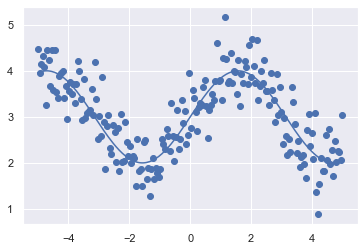

In [2]:
X = np.linspace(-5, 5, 200)
Y_org = np.sin(X) + 3
Y = Y_org + np.random.randn(200) * 0.5
plt.scatter(X, Y)
plt.plot(X, Y_org)

### Piecewise Regressions

In [3]:
class PiecewiseMean:
    def __init__(self, num_knots, degree=1):
        self.num_knots = num_knots
        self.degree = degree
        
    def fit_data(self, data, X_sub):
        return [data.mean()] * len(data)
        
    def get_predictions(self, X, Y):
        knots = self.num_knots + 1
        min_x = X.min()
        max_x = X.max()
        points = np.linspace(min_x, max_x, knots)
        results = []
        for i in range(1, points.shape[0]):
            mask = (points[i-1] <= X) & (X <= points[i])
            data = Y[mask]
            one_res = self.fit_data(data, X[mask])
            results.extend(one_res)
        self.points = points
        return np.array(results)
    
class PiecewiseCubic(PiecewiseMean):
    def fit_data(self, data, X_sub):
        poly = PolynomialFeatures(degree=self.degree)
        X_sub = poly.fit_transform(X_sub.reshape(-1,1))
        model = sm.OLS(data, sm.add_constant(X_sub)).fit()
        return model.predict()

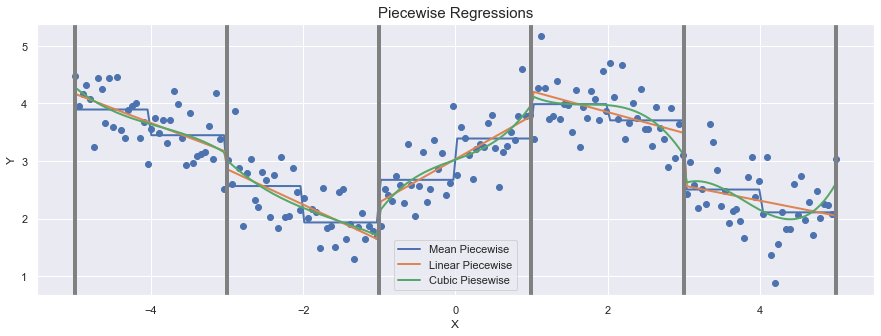

In [4]:
piecewise = PiecewiseMean(num_knots=10)
mean_pred = piecewise.get_predictions(X, Y)

cubic = PiecewiseCubic(num_knots=5, degree=1)
linear_pred = cubic.get_predictions(X, Y)

cubic = PiecewiseCubic(num_knots=5, degree=3)
cubic_pred = cubic.get_predictions(X, Y)

plt.figure(figsize=(15, 5))
    
plt.scatter(X, Y)
plt.plot(X, mean_pred, label='Mean Piecewise', linewidth=2)
plt.plot(X, linear_pred, label='Linear Piecewise', linewidth=2)
plt.plot(X, cubic_pred, label='Cubic Piesewise', linewidth=2)

xcoords = cubic.points
for xc in xcoords:
    plt.axvline(x=xc, color='grey', linewidth=4)

plt.title('Piecewise Regressions', fontsize=15)
plt.ylabel('Y')
plt.xlabel('X')
plt.legend()

### Splines

In [21]:
class BaseSpline:
    def __init__(self, num_knots):
        self.num_knots = num_knots
        
    def get_points(self, X):
        min_x = X.min()
        max_x = X.max()
        points = np.linspace(min_x, max_x, self.num_knots)
        return points

class CubicSplines(BaseSpline):
    def fit_data(self, X, Y):
        points = self.get_points(X)
        results = []
        poly = PolynomialFeatures(degree=3)
        X_sub = poly.fit_transform(X.reshape(-1,1))

        X_temp = np.zeros(shape=[X.shape[0], len(points)])
        for i, point in enumerate(points):
            rest = (X - point)**3
            X_rest = np.where(rest > 0, rest, 0)
            X_temp[:,i] = X_rest
        X_sub = np.hstack([X_temp, X_sub])
        model = sm.OLS(Y, sm.add_constant(X_sub)).fit()
        one_res = model.predict()
        results.extend(one_res)
        return np.array(results)
    
class NaturalSplines(BaseSpline):
    def get_k(self, X, points, k):
        left_X = (X - points[k]) ** 3
        left_X = np.where(left_X > 0, left_X, 0)

        right_X = (X - points[-1]) ** 3
        right_X = np.where(right_X > 0, right_X, 0)
        d = (left_X - right_X) / (points[-1] - points[k])
        return d

    def fit_data(self, X, Y):
        points = self.get_points(X)
        results = []
        poly = PolynomialFeatures(degree=3)
        X_sub = poly.fit_transform(X.reshape(-1,1))

        X_temp = np.zeros(shape=[X.shape[0], len(points)])
        for i, point in enumerate(points):
            if i == len(points) - 2:
                break
            X_k = self.get_k(X, points, i)
            X_K = self.get_k(X, points, len(points) - 2)
            d = X_k - X_K
            X_temp[:, i] = d
        X_sub = np.hstack([X_temp, X_sub])
        model = sm.OLS(Y, sm.add_constant(X_sub)).fit()
        one_res = model.predict()
        results.extend(one_res)
        return np.array(results)

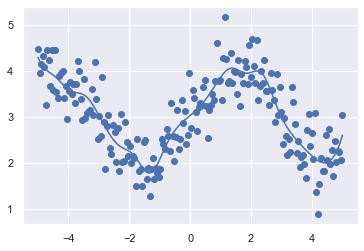

In [22]:
natural_spline = NaturalSplines(20)
results = natural_spline.fit_data(X, Y)

plt.scatter(X, Y)
plt.plot(X, results)

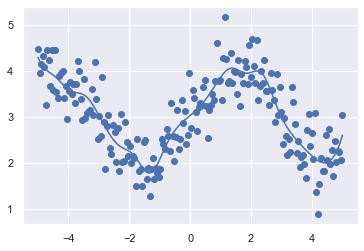

In [23]:
cubic_splines = CubicSplines(20)
results = cubic_splines.fit_data(X, Y)
plt.scatter(X, Y)
plt.plot(X, results)